In [25]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from random import sample
import scipy.stats as sps
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
current = os.path.abspath(os.getcwd())
sys.path.append(os.path.normpath(os.path.join(os.path.dirname(current), '..')))
from base.calibration import calibrator 
from base.emulation import emulator

# Example 3: Bayesian calibration of SIR epidemic model via Covid-19 data

## About data set

In [2]:
# Read data 
real_data = np.loadtxt('real_observations.csv', delimiter=',')
description = np.loadtxt('observation_description.csv', delimiter=',',dtype='object')
param_values = 1/np.loadtxt('param_values.csv', delimiter=',')
func_eval = np.loadtxt('func_eval.csv', delimiter=',')
param_values_test = 1/np.loadtxt('param_values_test.csv', delimiter=',')
func_eval_test = np.loadtxt('func_eval_test.csv', delimiter=',')

In [3]:
# Remove the initial 30-days time period from the data
keepinds = np.squeeze(np.where(description[:,0].astype('float') > 30))
real_data = real_data[keepinds]
description = description[keepinds, :]
func_eval = func_eval[:,keepinds]
func_eval_test = func_eval_test[:, keepinds]

In [4]:
print('N:', func_eval.shape[0])
print('D:', param_values.shape[1])
print('M:', real_data.shape[0])
print('P:', description.shape[1])

N: 2000
D: 10
M: 402
P: 2


In [5]:
# Get the random sample of 500
rndsample = sample(range(0, 2000), 500)
func_eval_rnd = func_eval[rndsample, :]
param_values_rnd = param_values[rndsample, :]

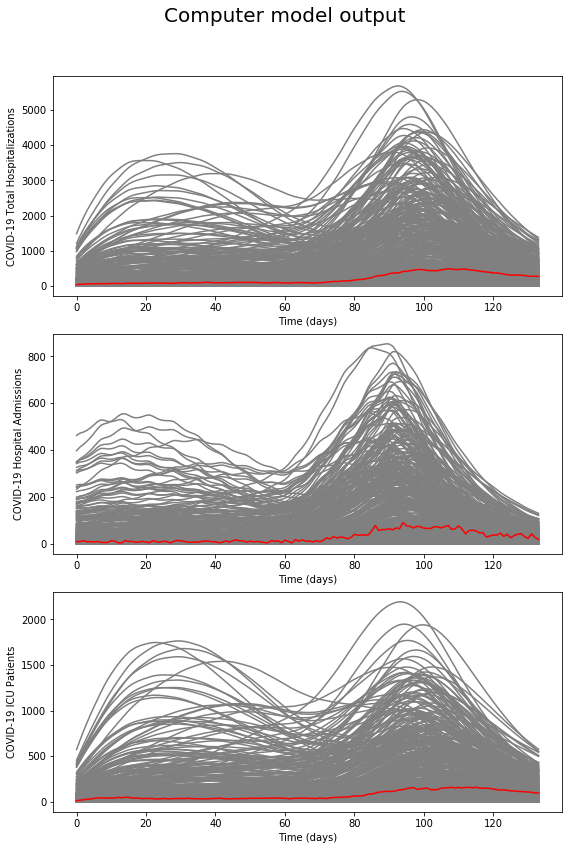

In [6]:
def plot_observed_data(description, func_eval, real_data, param_values, title = None):
    '''
    Plots a list of profiles in the same figure. Each profile corresponds
    to a stochastic replica for the given instance.
    '''
    plt.rcParams["font.size"] = "10"
    N = len(param_values)
    D = description.shape[1]
    T = len(np.unique(description[:,0]))
    type_no = len(np.unique(description[:,1]))
    fig, axs = plt.subplots(type_no, figsize=(8, 12))
    if title is not None:
        fig.suptitle(title, fontsize=20)
    for j in range(type_no):
        for i in range(N):
            axs[j].plot(range(T), func_eval[i,(j*T):(j*T + T)], color='grey')
        axs[j].plot(range(T), real_data[(j*T):(j*T + T)], color='red')
        if j == 0:
            axs[j].set_ylabel('COVID-19 Total Hospitalizations')
        elif j == 1:
            axs[j].set_ylabel('COVID-19 Hospital Admissions')
        elif j == 2:
            axs[j].set_ylabel('COVID-19 ICU Patients')
        axs[j].set_xlabel('Time (days)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.9) 
    plt.show()
    
plot_observed_data(description, func_eval_rnd, real_data, param_values_rnd, title='Computer model output')

## Fitting an emulator using two different methods

In [7]:
x = np.reshape(np.tile(range(134), 3), (402, 1))

### Method 1

In [8]:
# (No filter) Fit an emulator via 'PCGP_ozge'
emulator_1 = emulator(x, param_values_rnd, func_eval_rnd.T, method = 'PCGP_ozge', args = {'is_pca': True}) 
pred_1 = emulator_1.predict(x, param_values_rnd)
pred_mean_1 = pred_1.mean()

Function supplementtheta not found in module!
no of pcs: 6


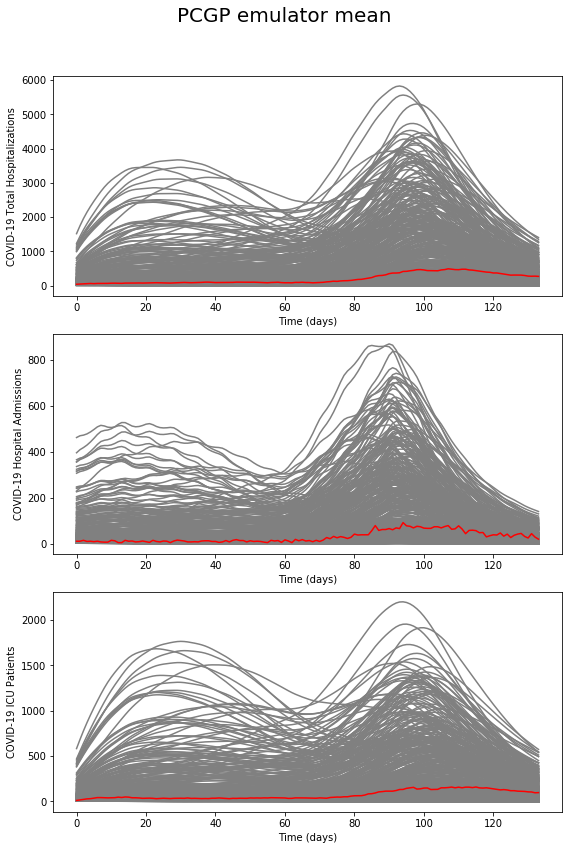

In [9]:
plot_observed_data(description, pred_mean_1.T, real_data, param_values_rnd, title='PCGP emulator mean')

### Method 2

In [10]:
# (No filter) Fit an emulator via 'PCGPwM'
emulator_2 = emulator(x, param_values_rnd, func_eval_rnd.T, method = 'PCGPwM') 
pred_2 = emulator_2.predict(x, param_values_rnd)
pred_mean_2 = pred_2.mean()

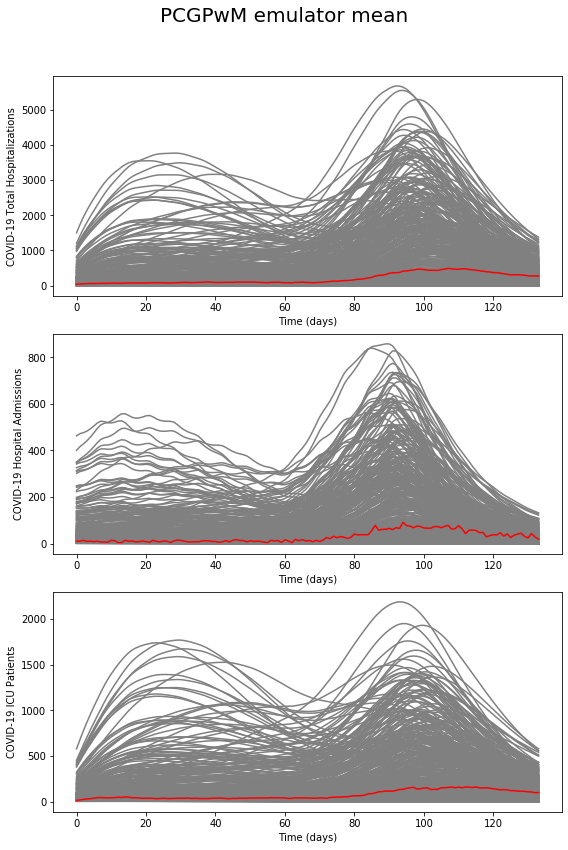

In [11]:
plot_observed_data(description, pred_mean_2.T, real_data, param_values_rnd, title='PCGPwM emulator mean')

## Fitting a calibrator

In [12]:
# Define a class for prior of 10 parameters
class prior_covid:
    """ This defines the class instance of priors provided to the method. """
    def lpdf(theta):
        return np.squeeze(sps.norm.logpdf(theta[:, 0], 2.5, 0.5) + 
                          sps.norm.logpdf(theta[:, 1], 4.0, 0.5) + 
                          sps.norm.logpdf(theta[:, 2], 4.0, 0.5) + 
                          sps.norm.logpdf(theta[:, 3], 1.875, 0.1) + 
                          sps.norm.logpdf(theta[:, 4], 14, 1.5) + 
                          sps.norm.logpdf(theta[:, 5], 18, 1.5) + 
                          sps.norm.logpdf(theta[:, 6], 20, 1.5) + 
                          sps.norm.logpdf(theta[:, 7], 14, 1.5) + 
                          sps.norm.logpdf(theta[:, 8], 13, 1.5) + 
                          sps.norm.logpdf(theta[:, 9], 12, 1.5))

    def rnd(n):
        return np.vstack((sps.norm.rvs(2.5, 0.5, size=n),
                          sps.norm.rvs(4.0, 0.5, size=n),
                          sps.norm.rvs(4.0, 0.5, size=n),
                          sps.norm.rvs(1.875, 0.1, size=n),
                          sps.norm.rvs(14, 1.5, size=n),
                          sps.norm.rvs(18, 1.5, size=n),
                          sps.norm.rvs(20, 1.5, size=n),
                          sps.norm.rvs(14, 1.5, size=n),
                          sps.norm.rvs(13, 1.5, size=n),
                          sps.norm.rvs(12, 1.5, size=n))).T

In [13]:
obsvar = np.maximum(0.2*real_data, 5)

In [14]:
cal_1 = calibrator(emulator_1, real_data, x, thetaprior = prior_covid, method = 'MLcal', yvar = obsvar, 
                   args = {'theta0': np.array([2, 4, 4, 1.875, 14, 18, 20, 14, 13, 12]), 
                           'numsamp' : 1000, 'stepType' : 'normal', 
                           'stepParam' : np.array([0.01, 0.01, 0.01, 0.01, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03])})

n_acc rate= 0.13


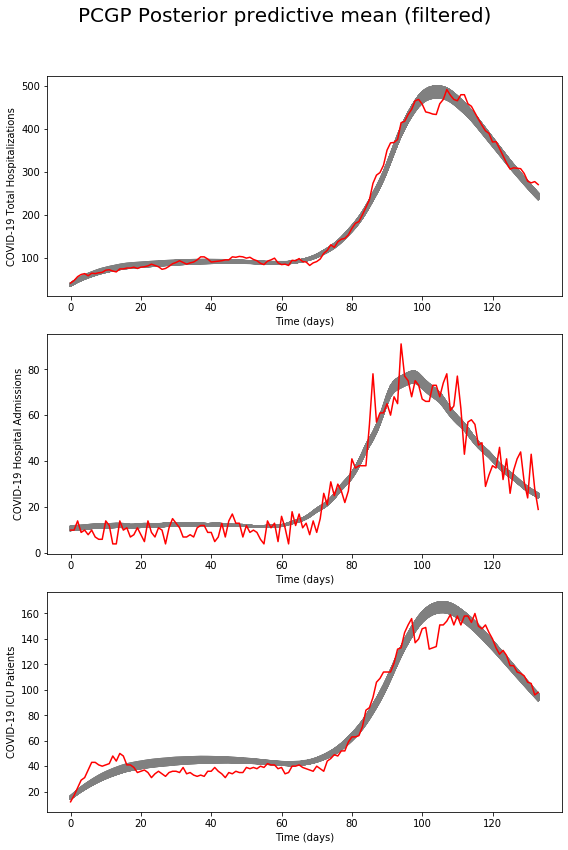

In [15]:
cal_1_theta = cal_1.theta.rnd(1000) 
pred_cal_1 = emulator_1.predict(x, cal_1_theta)
pred_mean_cal_1 = pred_cal_1.mean()
plot_observed_data(description, pred_mean_cal_1.T, real_data, cal_1_theta, title='PCGP Posterior predictive mean (filtered)')

In [16]:
cal_2 = calibrator(emulator_2, real_data, x, thetaprior = prior_covid, method = 'MLcal', yvar = obsvar, 
                   args = {'theta0': np.array([2, 4, 4, 1.875, 14, 18, 20, 14, 13, 12]), 
                           'numsamp' : 1000, 'stepType' : 'normal', 
                           'stepParam' : np.array([0.01, 0.01, 0.01, 0.01, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03])})

n_acc rate= 0.119


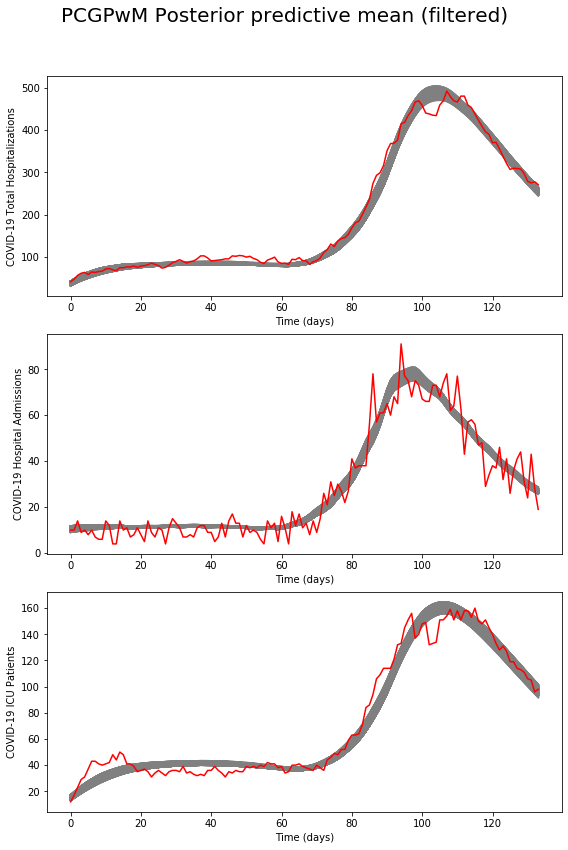

In [17]:
cal_2_theta = cal_2.theta.rnd(1000) 
pred_cal_2 = emulator_2.predict(x, cal_2_theta)
pred_mean_cal_2 = pred_cal_2.mean()
plot_observed_data(description, pred_mean_cal_2.T, real_data, cal_2_theta, title='PCGPwM Posterior predictive mean (filtered)')

## A new way of calibration:  Calibration via filtered data

### Filter out the data

In [18]:
# Filter out the data and fit a new emulator with the filtered data 
par_out = param_values_rnd[np.logical_or.reduce((func_eval_rnd[:, 100] <= 200, func_eval_rnd[:, 20] >= 1000, func_eval_rnd[:, 100] >= 1000)),:]
par_in = param_values_rnd[np.logical_and.reduce((func_eval_rnd[:, 100] > 200, func_eval_rnd[:, 20] < 1000, func_eval_rnd[:, 100] < 1000)), :]
func_eval_in = func_eval_rnd[np.logical_and.reduce((func_eval_rnd[:, 100] > 200, func_eval_rnd[:, 20] < 1000, func_eval_rnd[:, 100] < 1000)), :]
par_in_test = param_values_test[np.logical_and.reduce((func_eval_test[:, 100] > 200, func_eval_test[:, 20] < 1000, func_eval_test[:, 100] < 1000)), :]
func_eval_in_test = func_eval_test[np.logical_and.reduce((func_eval_test[:, 100] > 200, func_eval_test[:, 20] < 1000, func_eval_test[:, 100] < 1000)), :]

### Fitting an emulatior with method 1 (filtered)

In [19]:
# (Filter) Fit an emulator via 'PCGP_ozge'
emulator_f_1 = emulator(x, par_in, func_eval_in.T, method = 'PCGP_ozge', args = {'is_pca': True}) 
pred_f_1 = emulator_f_1.predict(x, par_in)
pred_mean_f_1 = pred_f_1.mean()

Function supplementtheta not found in module!
no of pcs: 5


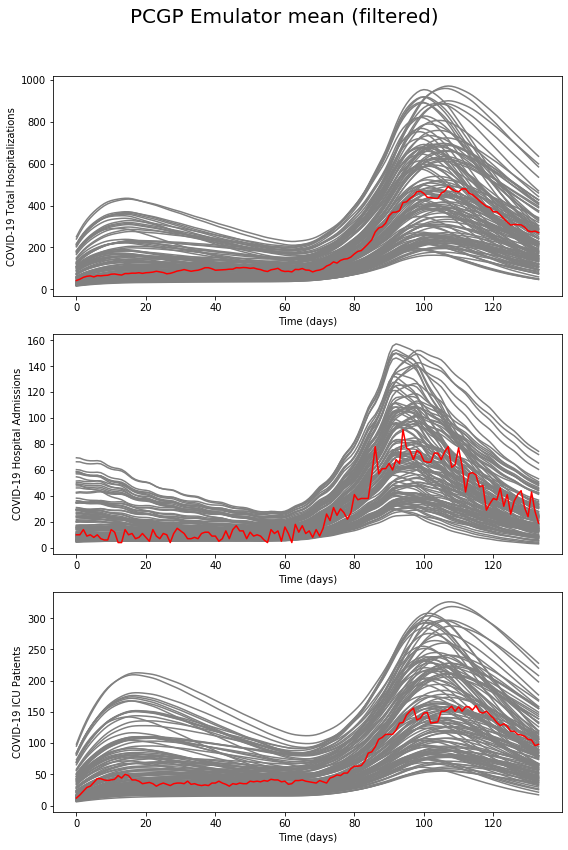

In [20]:
plot_observed_data(description, pred_mean_f_1.T, real_data, par_in, title='PCGP Emulator mean (filtered)')

### Fitting an emulatior with method 2 (filtered)

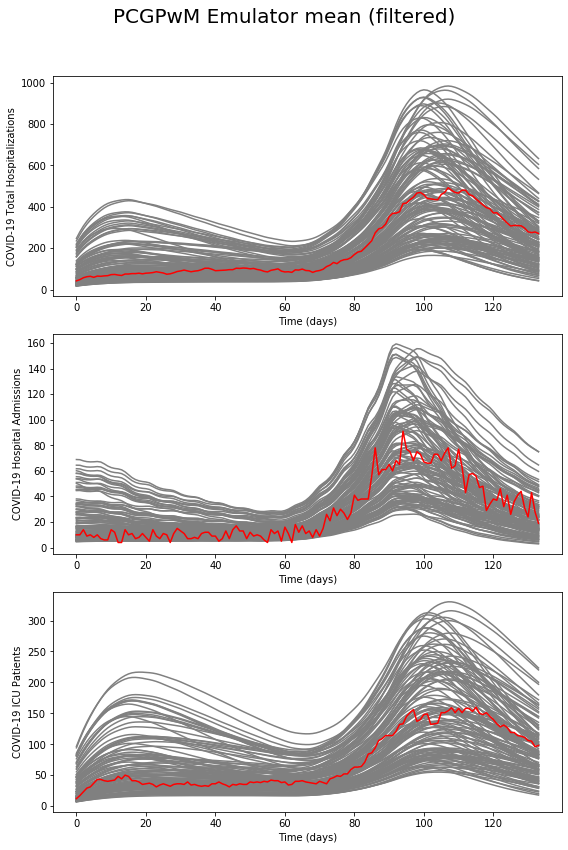

In [21]:
# (Filter) Fit an emulator via 'PCGPwM'
emulator_f_2 = emulator(x, par_in, func_eval_in.T, method = 'PCGPwM') 
pred_f_2 = emulator_f_2.predict(x, par_in)
pred_mean_f_2 = pred_f_2.mean()

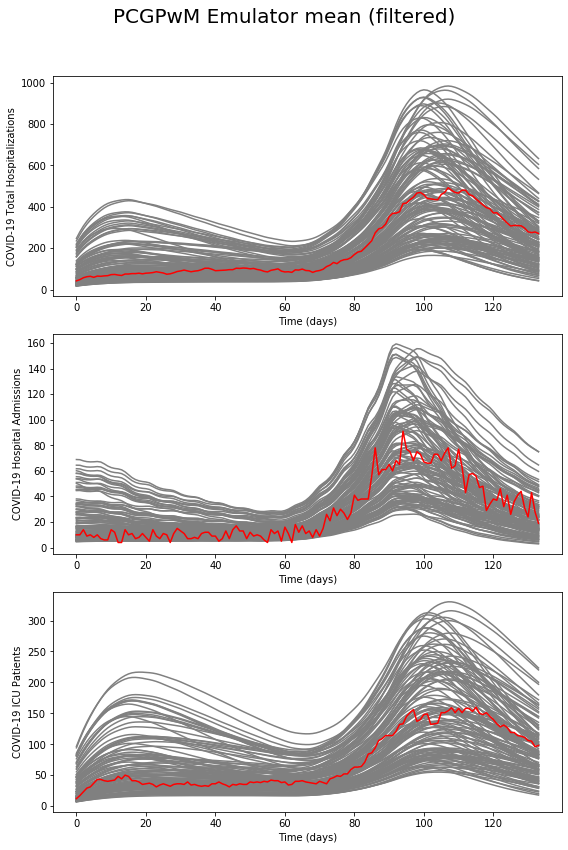

In [22]:
plot_observed_data(description, pred_mean_f_2.T, real_data, par_in, title='PCGPwM Emulator mean (filtered)')

### Compare emulators

In [24]:
# Compare emulators
pred_1_test = emulator_1.predict(x, par_in_test)
pred_mean_test_1 = pred_1_test.mean()

print(np.mean(np.sum(np.square(pred_mean_test_1 - func_eval_in_test.T), axis = 1)))

pred_2_test = emulator_2.predict(x, par_in_test)
pred_mean_2_test = pred_2_test.mean()

print(np.mean(np.sum(np.square(pred_mean_2_test - func_eval_in_test.T), axis = 1)))

pred_f_1_test = emulator_f_1.predict(x, par_in_test)
pred_mean_test_f_1 = pred_f_1_test.mean()

print(np.mean(np.sum(np.square(pred_mean_test_f_1 - func_eval_in_test.T), axis = 1)))

pred_f_2_test = emulator_f_2.predict(x, par_in_test)
pred_mean_test_f_2 = pred_f_2_test.mean()

print(np.mean(np.sum(np.square(pred_mean_test_f_2 - func_eval_in_test.T), axis = 1)))

567502.9639311513
544493.2089334066
140156.41624328724
147102.2598306474


## Fit a classification model to predict filtered results

In [30]:
y = np.zeros(len(pred_mean_1.T))
y[np.logical_and.reduce((pred_mean_1.T[:, 100] > 200, pred_mean_1.T[:, 20] < 1000, pred_mean_1.T[:, 100] < 1000))] = 1
 
# Create the test data
pred_1_test = emulator_1.predict(x, param_values_test)
pred_mean_1_test = pred_1_test.mean()
y_test = np.zeros(len(pred_mean_1_test.T))
y_test[np.logical_and.reduce((pred_mean_1_test.T[:, 100] > 200, pred_mean_1_test.T[:, 20] < 1000, pred_mean_1_test.T[:, 100] < 1000))] = 1

# Create a balanced data set
X_0 = param_values_rnd[y == 0][0:130]
y_0 = y[y == 0][0:130]
X_1 = param_values_rnd[y == 1]
y_1 = y[y == 1]
    
X = np.concatenate((X_0, X_1), axis=0)
y = np.concatenate((y_0, y_1), axis=0)

# Fit the classification model
model = RandomForestClassifier(n_estimators = 100, random_state = 42)
model.fit(X, y)

#Training accuracy
print(model.score(X, y))
print(confusion_matrix(y, model.predict(X)))

#Test accuracy
print(model.score(param_values_test, y_test))
print(confusion_matrix(y_test, model.predict(param_values_test)))

1.0
[[130   0]
 [  0 122]]
0.6795
[[1100  464]
 [ 177  259]]


## Fitting a calibrator via ML adjusted calibration

In [31]:
cal_f_ml_1 = calibrator(emulator_f_1, real_data, x, thetaprior = prior_covid, method = 'MLcal', yvar = obsvar, 
                        args = {'clf_method': model, 'theta0': np.array([2, 4, 4, 1.875, 14, 18, 20, 14, 13, 12]), 
                                'numsamp' : 1000, 'stepType' : 'normal', 
                                'stepParam' : np.array([0.01, 0.01, 0.01, 0.01, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03])})

n_acc rate= 0.116


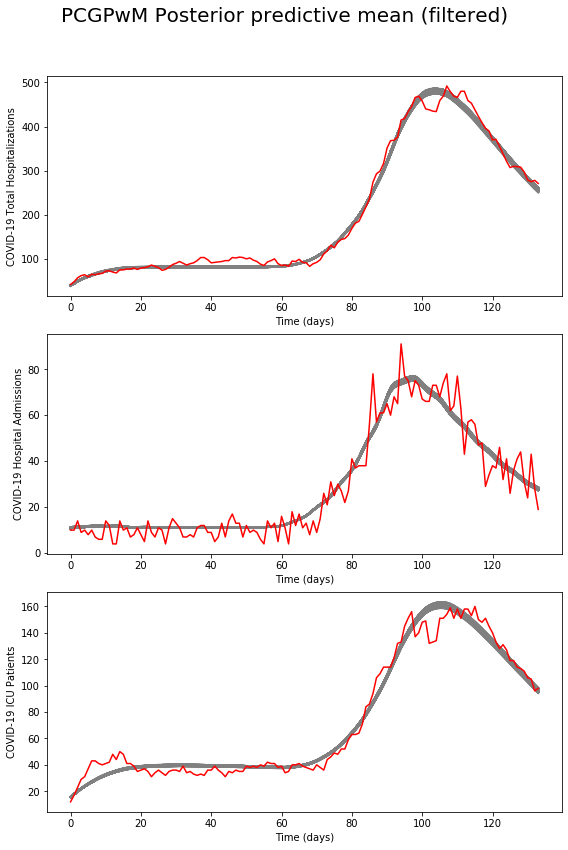

In [32]:
cal_f_ml_1_theta = cal_f_ml_1.theta.rnd(1000) 
pred_cal_f_ml_1 = emulator_f_1.predict(x, cal_f_ml_1_theta)
pred_mean_cal_f_ml_1 = pred_cal_f_ml_1.mean()
plot_observed_data(description, pred_mean_cal_f_ml_1.T, real_data, cal_f_ml_1_theta, title='PCGPwM Posterior predictive mean (filtered)')

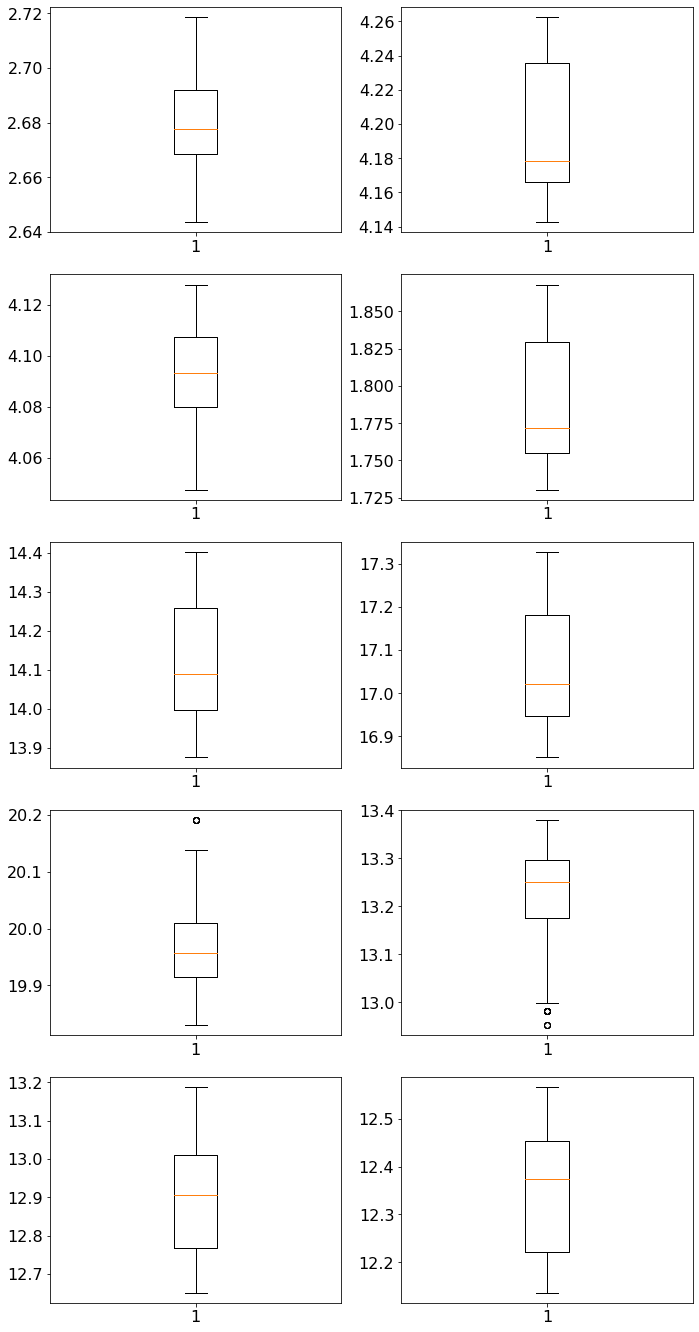

In [35]:
plt.rcParams["font.size"] = "16"
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
paraind = 0
for i in range(5):
    for j in range(2):
        axs[i, j].boxplot(cal_f_ml_1_theta[:, paraind])
        paraind += 1

fig.tight_layout()
fig.subplots_adjust(bottom=0.05, top=0.95)
plt.show()